In [1]:
import numpy as np; import pandas as pd; 
import xarray as xr; import sys; import matplotlib.pyplot as plt
sys.path.insert(0,'/mnt/sda1/PhysOc/modview/modview')
import loader, viztools
argo_path = '/mnt/sda1/SciData/'
import os, importlib, datetime
from dateutil.relativedelta import relativedelta

To describe the process of finding, loading, and visualizing data in modview, below is an example that uses the Roemmich-Gilson Argo climatology (https://sio-argo.ucsd.edu/RG_Climatology.html). 

We begin with a description of how this data will be referenced in databases. This helps streamline loading data with the loader.assemble class.

In [2]:
importlib.reload(loader)
# I'll do this by hand, but change it such that it can be done with the databases
argo_lims = {'t0':'none','t1':'none'}
argo_id = {'name':'Climatology','project':'ARGO','type':'Global','limits':argo_lims}
argo_directory = '/mnt/sda1/SciData/ARGO/'

clim_path = argo_directory+'RG_ArgoClim_Temperature_2019.nc' # months from 2004 to 2018
month_paths = [argo_directory+'RG_ArgoClim_'+year+month+'_2019.nc' for month in \
                    ['01','02','03','04','05','06','07','08','09','10','11','12'] \
                    for year in ['2019','2020']] 
month_paths.insert(0, clim_path) # climatology and monthly update files in a single list
argo_paths = {'T_mean':month_paths[0], 'T_anom':month_paths} # assign variables to files
# Create class instance
RG_clim = loader.assemble(argo_id,argo_paths)

At this point, all information necessary to load data from the RG climatology has been loaded onto the object 'RG_clim,' but the data itself has not been accessed. Depending on how your original files are structured and how you want to structure your own analysis, it is adviseable that you take some time to write the following steps into repeatable functions that give your data the specific format and names that will make analysis easiest. 

In this case, to load the data and start working with it, we do:

In [3]:
# Access the variable 'ARGO_TEMPERATURE_MEAN' in the .nc file and store it as RG_clim.grids['Temp_mean']
RG_clim.store_nc([argo_paths['T_mean']],['ARGO_TEMPERATURE_MEAN'], saveas=['Temp_mean'], decode_times=False)
# Now the monthly anomalies
RG_clim.store_nc(argo_paths['T_anom'],['ARGO_TEMPERATURE_ANOMALY'], saveas=['Temp_month'], decode_times=False)

In [4]:
# THIS IS WHERE I WILL HAVE TO FIGURE OUT HOW TO MERGE ALL ANOMALY FILES IN THE TEMPORAL DIMENSION 
# IN THE PAST, I USED INTERP_GRID TO MERGE ADCP FILES IN THE VERTICAL DIRECTION, SO I MIGHT WANT TO 
# TRANSLATE SOME PARTS OF THAT FUNCTION INTO SOMETHING MORE ABSTRACT THAT WILL WORK WITH MANY DIFFERENT 
# MERGING METHODS (NOT ONLY INTERPOLATION) AND FOR ANY DIMENSION

Monthly temperature anomalies in this dataset are categorized by the number of months since January of 2004. Let us quickly turn those dates into the datetime form. (This is the type of tasks that are specific to individual datasets and should be stored into a set of project-specific functions that interface with loader).

In [5]:
base_date = datetime.datetime(2004,1,15);
tlist = RG_clim.grids['Temp_month'][0].TIME.values;
dt = [base_date + relativedelta(months=+np.floor(nmonths)) for nmonths in tlist]
RG_clim.grids['Temp_month'][0]['TIME'] = dt

For this example, we will only focus on upper ocean temperatures in the Western Pacific Ocean. Therefore, we will choose only a subset of the data available. 

In [6]:
var2cut = [RG_clim.grids['Temp_month'][0], RG_clim.grids['Temp_mean'][0]];
def cut_argo(item,lon,lat,pres):
    item = item.sel(LONGITUDE=slice(lon[0],lon[1]));
    item = item.sel(LATITUDE=slice(lat[0],lat[1]));
    item = item.sel(PRESSURE=slice(pres[0],pres[1]));
    return item
LON = [100,150]; LAT = [5,25]; PRES = [0,150];
RG_clim.grids['Temp_month'] = cut_argo(RG_clim.grids['Temp_month'][0], LON, LAT, PRES)
RG_clim.grids['Temp_mean'] = cut_argo(RG_clim.grids['Temp_mean'][0], LON, LAT, PRES)

# Add mean to have real temperatures
RG_clim.grids['Temp_month'] = RG_clim.grids['Temp_month'] + RG_clim.grids['Temp_mean']

Let's plot the multiannual evolution of SST at 134.7 E, 15.7 N since 2004. 

In [7]:
RG_SIO3 = RG_clim.grids['Temp_month'].sel(PRESSURE=0,method='nearest')
RG_SIO3 = RG_SIO3.sel(LONGITUDE=134.7,method='nearest')
RG_SIO3 = RG_SIO3.sel(LATITUDE=15.7,method='nearest')

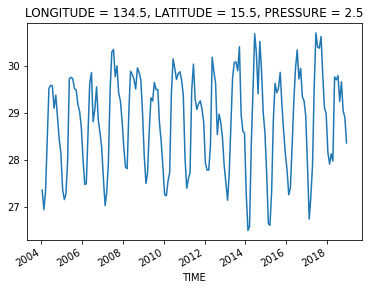

In [8]:
RG_SIO3.plot()

In [96]:
RG_SIO3.TIME[-1]

<xarray.DataArray 'TIME' ()>
array('2018-12-15T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    LONGITUDE  float32 134.5
    LATITUDE   float32 15.5
    PRESSURE   float32 2.5
    TIME       datetime64[ns] 2018-12-15